# Collaborative Filtering

This demo is derived from these articles [1](https://machinelearningcoban.com/2017/05/24/collaborativefiltering/) [2](https://machinelearningcoban.com/2017/05/31/matrixfactorization/)

Agenda

- Dataset
- Collaborative Filtering using k-Nearest Neighbors
- Collaborative Filtering using Matrix Factorization

## Import

In [3]:
import pandas as pd 
import numpy as np

## Dataset

MovieLens 100k was published in 1998 by GroupLens. This dataset contains 100,000 ratings from 943 users to 1682 movies. By the time, the dataset has been updated. Now, there are larger version of the dataset, which are 1M, 10M, 20M ratings.

In [1]:
# Download dataset
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ./ml-100k.zip

--2021-08-27 03:19:39--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  17.1MB/s    in 0.3s    

2021-08-27 03:19:40 (17.1 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ./ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.

After extractings, the structure of data folder goes as follow:

- u.data: Total ratings of 943 users to 1682 movies. Each user rates at least 20 movies. The ratings time is also included in Unix format but we do not use this feature in this demo.

- ua.base, ua.test, ub.base, ub.test: The data sets ua.base, ua.test, ub.base, and ub.test split the u data into a training set and a test set with exactly 10 ratings per user in the test set. The set ua.test and ub.test are disjoint.

- u.user: demographic information about the users; this is a tab separated list of user id | age | gender | occupation | zip code. The user ids are the ones used in the u.data data set.

- u.genre: List of 19 genres: unknown, Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western

- u.item: Information about the items

In [4]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings_base = pd.read_csv('ml-100k/ub.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('ml-100k/ub.test', sep='\t', names=r_cols, encoding='latin-1')

In [ ]:
ratings_base.shape

(90570, 4)

In [6]:
ratings_base.head()

,user_id,movie_id,rating,unix_timestamp
0,0,0,5,874965758
1,0,1,3,876893171
2,0,2,4,878542960
3,0,3,3,876893119
4,0,4,3,889751712


user ID and item ID start from 1 so we convert them to zero based index for sake of convenient. Just simply extract by 1

In [5]:
rate_train = ratings_base.values
rate_test = ratings_test.values

# indices start from 0
rate_train[:, :2] -= 1
rate_test[:, :2] -= 1

## Collaborative Filtering using k Nearest Neighbor

In this section, we are going to implement CF using kNN. We will cover some important part:

- Normalize data
- Similarity function
- Predict score
- Measure loss value

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse 

In [9]:
class CF(object):
    
    def __init__(
        self, 
        Y_data, # train data, list of records (user, item, ratings) 
        k, # number of neighbors
        dist_func = cosine_similarity, # similarity function
        uuCF = 1): # mode
        
        self.uuCF = uuCF # user-user (1) or item-item (0) CF
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]]
        self.k = k
        self.dist_func = dist_func
        self.Ybar_data = None
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1 
        self.n_items = int(np.max(self.Y_data[:, 1])) + 1
    
    def normalize_Y(self):
        users = self.Y_data[:, 0] # all users - first col of the Y_data
        self.Ybar_data = self.Y_data.copy()
        self.mu = np.zeros((self.n_users,))
        for n in range(self.n_users):
            # row indices of rating done by user n
            # since indices need to be integers, we need to convert
            ids = np.where(users == n)[0].astype(np.int32)
            # indices of all ratings associated with user n
            item_ids = self.Y_data[ids, 1] 
            # and the corresponding ratings 
            ratings = self.Y_data[ids, 2]
            # take mean
            m = np.mean(ratings) 
            if np.isnan(m):
                m = 0 # to avoid empty array and nan value
            self.mu[n] = m
            # normalize
            self.Ybar_data[ids, 2] = ratings - self.mu[n]

        ################################################
        # form the rating matrix as a sparse matrix. Sparsity is important 
        # for both memory and computing efficiency. For example, if #user = 1M, 
        # #item = 100k, then shape of the rating matrix would be (100k, 1M), 
        # you may not have enough memory to store this. Then, instead, we store 
        # nonzeros only, and, of course, their locations.
        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
            (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.tocsr()

    def similarity(self):
        self.S = self.dist_func(
            self.Ybar.T, # (n_samples_X, n_features)
            self.Ybar.T) # (n_samples_Y, n_features)
                         # ==> (n_samples_X, n_samples_Y)
    
    def fit(self):
        self.normalize_Y()
        self.similarity()
            
    def __pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized)
        """
        # Step 1: find all users who rated i
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
        # Step 2: find similarity btw the current user and others 
        # who already rated i
        sim = self.S[u, users_rated_i]
        # Step 4: find the k most similarity users
        a = np.argsort(sim)[-self.k:] 
        # and the corresponding similarity levels
        nearest_s = sim[a]
        # How did each of 'near' users rated item i
        r = self.Ybar[i, users_rated_i[a]]
        if normalized:
            # add a small number, for instance, 1e-8, to avoid dividing by 0
            return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8)

        return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8) + self.mu[u]
    
    def pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized)
        if you need the un
        """
        if self.uuCF: return self.__pred(u, i, normalized)
        return self.__pred(i, u, normalized)
            
    
    def recommend(self, u):
        """
        Determine all items should be recommended for user u.
        The decision is made based on all i such that:
        self.pred(u, i) > 0. Suppose we are considering items which 
        have not been rated by u yet. 
        """
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = self.Y_data[ids, 1].tolist()              
        recommended_items = []
        recommended_ratings = []
        
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                rating = self.__pred(u, i)
                if rating > 0: 
                    recommended_items.append(i)
                    recommended_ratings.append(rating)
        
        return recommended_items, recommended_ratings

    def print_recommendation(self, u, topk=5):
        """
        print all items which should be recommended for user 
        """
        print('Recommendation: ')
    
        recommended_items, recommended_ratings = self.recommend(u)

        indices = np.argsort(recommended_ratings)
        topk_indices = indices[-topk:]

        if self.uuCF:
            print ('    Recommend item(s):', 
                   [recommended_items[i] for i in topk_indices], 
                   'for user', u)
        else: 
            # item-item mode, in this case, u is an item id
            print ('    Recommend item', u, 'for user(s) : ', 
                   [recommended_items[i] for i in topk_indices])

In [10]:
rs = CF(rate_train, k = 30, uuCF = 1)
rs.fit()

n_tests = rate_test.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs.pred(rate_test[n, 0], rate_test[n, 1], normalized = 0)
    SE += (pred - rate_test[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print ('User-user CF, RMSE =', RMSE)

User-user CF, RMSE = 0.9951981100882598


In [ ]:
rs.print_recommendation(10, topk=5)

Recommendation: 
    Recommend item(s): [1677, 1625, 1471, 1659, 1658] for user 10


In [ ]:
rs = CF(rate_train, k = 30, uuCF = 0)
rs.fit()

n_tests = rate_test.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs.pred(rate_test[n, 0], rate_test[n, 1], normalized = 0)
    SE += (pred - rate_test[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print ('Item-item CF, RMSE =', RMSE)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Item-item CF, RMSE = 0.9867912132705384


In [ ]:
rs.print_recommendation(10, topk=5)

Recommendation: 
    Recommend item 10 for user(s) :  [518, 906, 117, 506, 938]


## Collaborative Filtering using Matrix Factorization

#### Matrix Factorization

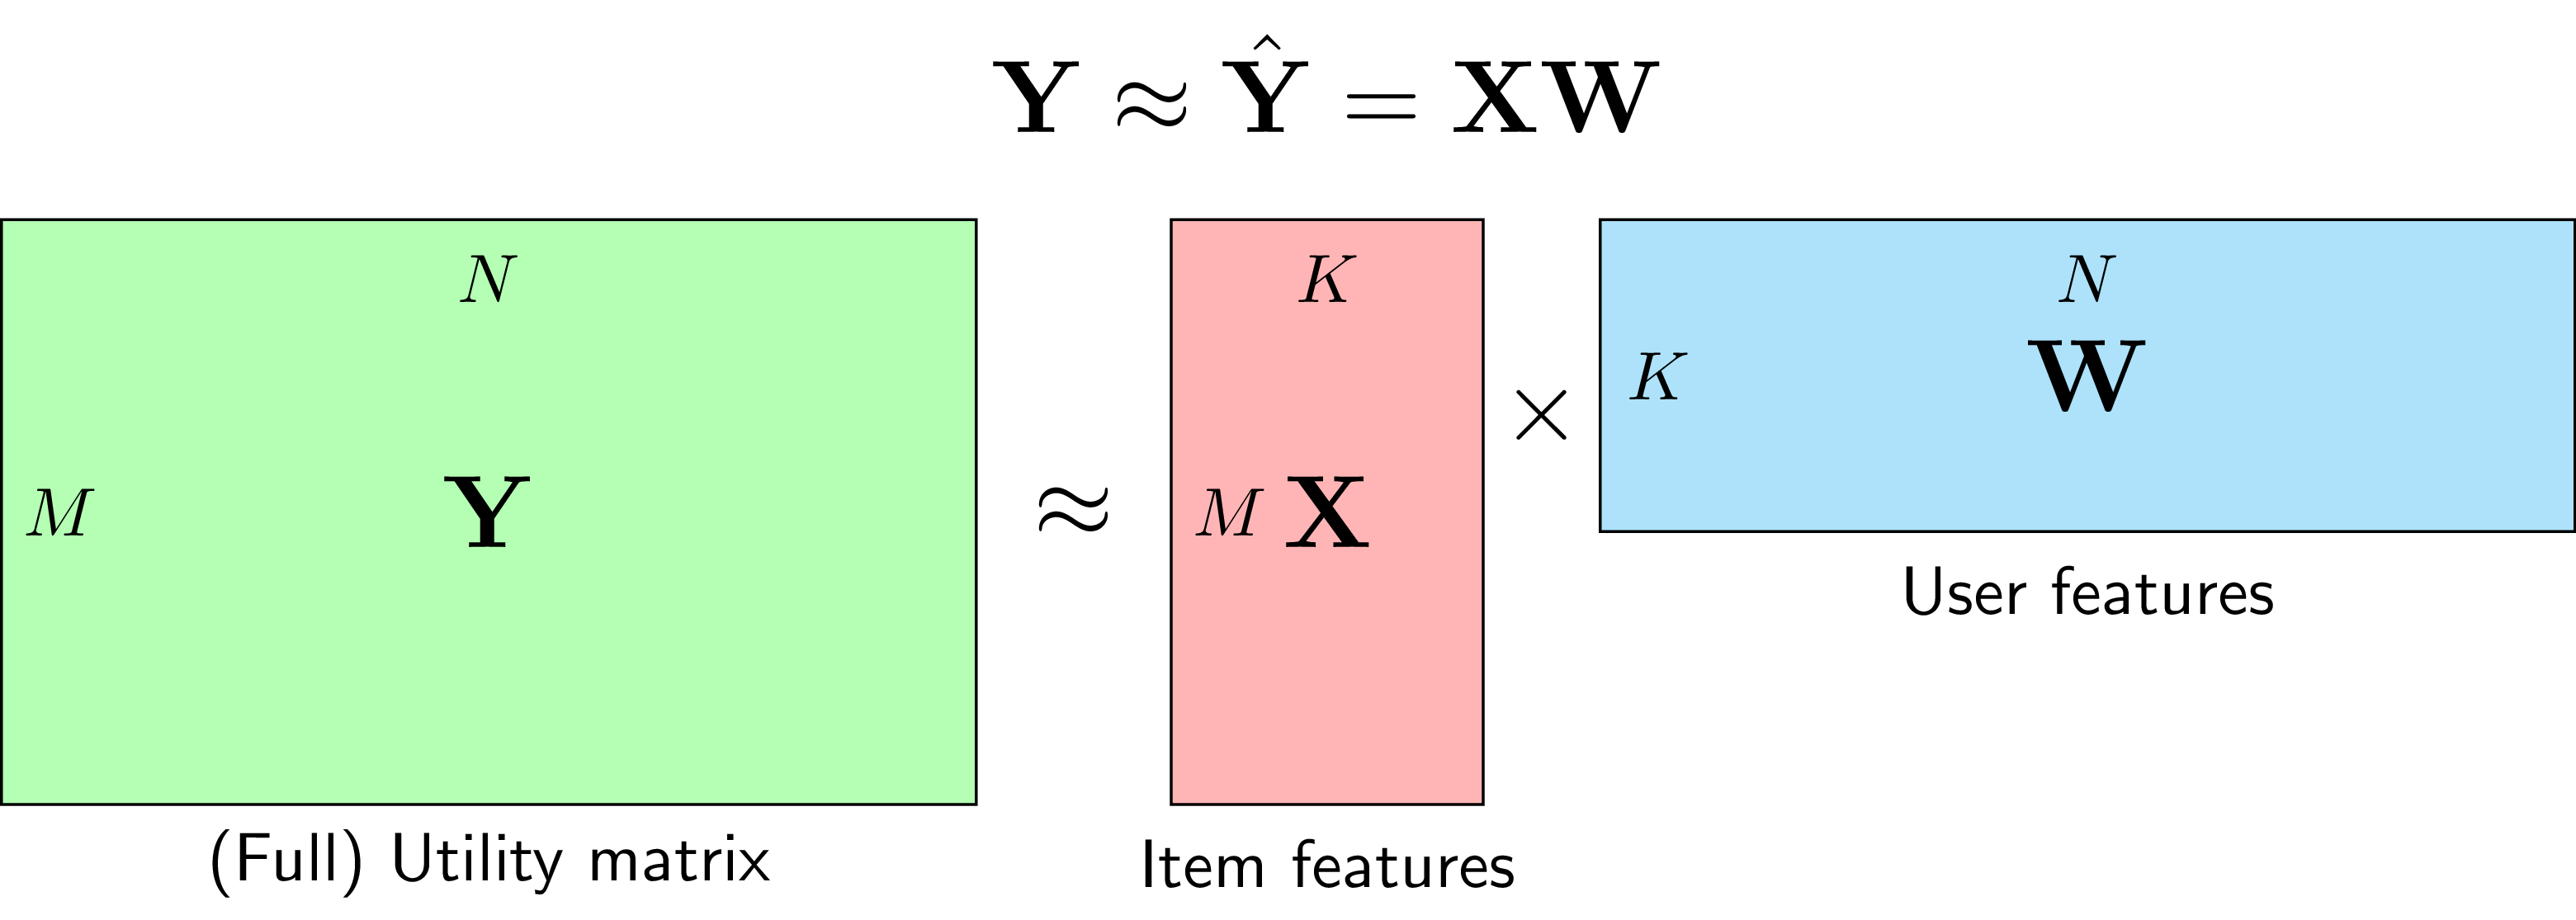

Loss function 
$$\mathcal{L}(\mathbf{X}, \mathbf{W}) = \frac{1}{2s} \sum_{n=1}^N \sum_{m:r_{mn} = 1} (y_{mn} - \mathbf{x}_m\mathbf{w}_n)^2 + \frac{\lambda}{2} (||\mathbf{X}||_F^2 + ||\mathbf{W}||_F^2) $$

where 

X is item profiles matrix

W is user profiles matrix

$||\bullet||_F^2$ is Frobenious norm

To optimize both X and W is quite complicated. There is an simpler way, which are optimizing X and W sequently.
We will use Gradient Descent to optimize.

We separate the mentioned aboved loss function into N smaller function, in which we will optimize a column of W:
$$\mathcal{L}(\mathbf{w}_n) = \frac{1}{2s} \sum_{m:r_{mn} = 1} (y_{mn} - \mathbf{x}_m\mathbf{w}_n)^2 + \frac{\lambda}{2}||\mathbf{w}_n||_2^2$$

Let $\hat{\mathbf{X}}_n$ is the compact version of $\mathbf{X}$, contain all item rated by user n.

Hence, the small loss function is rewritten as:
$$\mathcal{L}(\mathbf{w}_n) = \frac{1}{2s} ||\hat{\mathbf{y}}_n - \hat{\mathbf{X}}_n\mathbf{w}_n||^2 + \frac{\lambda}{2}||\mathbf{w}_n||_2^2$$

and its derivation:
$$\frac{\partial \mathcal{L}(\mathbf{w}_n)}{\partial \mathbf{w}_n} = -\frac{1}{s}\hat{\mathbf{X}}_n^T(\hat{\mathbf{y}}_n - \hat{\mathbf{X}}_n\mathbf{w}_n) + \lambda \mathbf{w}_n$$

Then, the update formula for $\mathbf{w}_n$:
$$\mathbf{w}_n = \mathbf{w}_n - \eta \left(-\frac{1}{s}\hat{\mathbf{X}}_n^T (\hat{\mathbf{y}}_n - \hat{\mathbf{X}}_n\mathbf{w}_n) + \lambda \mathbf{w}_n\right)$$


Similarly, the update formula of $\mathbf{x}_n$:
$$\mathbf{x}_m = \mathbf{x}_m - \eta\left(-\frac{1}{s}(\hat{\mathbf{y}}^m - \mathbf{x}_m\hat{\mathbf{W}}_m)\hat{\mathbf{W}}_m^T + \lambda \mathbf{x}_m\right)$$

In [11]:
class MF(object):
    
    def __init__(
        self, 
        Y_data, # utility matrix
        K, # number of latent features
        lam = 0.1, # regularization param
        Xinit = None, # item profiles matrix 
        Winit = None, # user profiles matrix                 
        learning_rate = 0.5, 
        max_iter = 1000, 
        print_every = 100, 
        user_based = 1): # mode user based (1) or item based (0)

        self.Y_raw_data = Y_data
        self.K = K
        self.lam = lam
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.print_every = print_every
        self.user_based = user_based
        
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = int(np.max(Y_data[:, 0])) + 1 
        self.n_items = int(np.max(Y_data[:, 1])) + 1
        
        if Xinit is None: 
            self.X = np.random.randn(self.n_items, K)
        else:
            self.X = Xinit 
        
        if Winit is None: 
            self.W = np.random.randn(K, self.n_users)
        else: 
            self.W = Winit
            
        #self.all_users = self.Y_data[:,0] # all users (may be duplicated)
        self.n_ratings = Y_data.shape[0]
        # normalized data
        self.Y_data_n = self.Y_raw_data.copy()

    def normalize_Y(self):
        if self.user_based:
            user_col = 0
            item_col = 1
            n_objects = self.n_users
        else:
            user_col = 1
            item_col = 0 
            n_objects = self.n_items

        users = self.Y_raw_data[:, user_col] 
        self.mu = np.zeros((n_objects,))
        for n in range(n_objects):
            # row indices of rating done by user n
            # since indices need to be integers, we need to convert
            ids = np.where(users == n)[0].astype(np.int32)
            # indices of all ratings associated with user n
            item_ids = self.Y_data_n[ids, item_col] 
            # and the corresponding ratings 
            ratings = self.Y_data_n[ids, 2]
            # take mean
            m = np.mean(ratings) 
            if np.isnan(m):
                m = 0 # to avoid empty array and nan value
            self.mu[n] = m
            # normalize
            self.Y_data_n[ids, 2] = ratings - self.mu[n]
            
    
    def loss(self):
        L = 0 
        for i in range(self.Y_data_n.shape[0]):
            # user, item, rating
            n, m, rate = int(self.Y_data_n[i, 0]), int(self.Y_data_n[i, 1]), self.Y_data_n[i, 2]
            L += 0.5*(rate - self.X[m, :].dot(self.W[:, n]))**2
            
        # regularization 
        L /= self.n_ratings
        L += 0.5*self.lam*(np.linalg.norm(self.X, 'fro') + np.linalg.norm(self.W, 'fro'))
        return L 

    
    def get_items_rated_by_user(self, user_id):
        """
        get all items which are rated by user n, and the corresponding ratings
        """
        # y = self.Y_data_n[:,0] # all users (may be duplicated)
        # item indices rated by user_id
        # we need to +1 to user_id since in the rate_matrix, id starts from 1 
        # while index in python starts from 0
        ids = np.where(self.Y_data_n[:,0] == user_id)[0] 
        item_ids = self.Y_data_n[ids, 1].astype(np.int32) # index starts from 0 
        ratings = self.Y_data_n[ids, 2]
        return (item_ids, ratings)
        
        
    def get_users_who_rate_item(self, item_id):
        """
        get all users who rated item m and get the corresponding ratings
        """
        ids = np.where(self.Y_data_n[:,1] == item_id)[0] 
        user_ids = self.Y_data_n[ids, 0].astype(np.int32)
        ratings = self.Y_data_n[ids, 2]
        return (user_ids, ratings)
        
    def updateX(self):
        for m in range(self.n_items):
            user_ids, ratings = self.get_users_who_rate_item(m)
            Wm = self.W[:, user_ids]
            grad_xm = -(ratings - self.X[m, :].dot(Wm)).dot(Wm.T)/self.n_ratings + \
                                               self.lam*self.X[m, :]
            self.X[m, :] -= self.learning_rate*grad_xm.reshape((self.K,))
    
    def updateW(self):
        for n in range(self.n_users):
            item_ids, ratings = self.get_items_rated_by_user(n)
            Xn = self.X[item_ids, :]
            grad_wn = -Xn.T.dot(ratings - Xn.dot(self.W[:, n]))/self.n_ratings + \
                        self.lam*self.W[:, n]
            self.W[:, n] -= self.learning_rate*grad_wn.reshape((self.K,))
    
    def fit(self):
        self.normalize_Y()
        for it in range(self.max_iter):
            self.updateX()
            self.updateW()
            if (it + 1) % self.print_every == 0:
                rmse_train = self.evaluate_RMSE(self.Y_raw_data)
                print('iter =', it + 1, 
                      ', loss =', self.loss(), 
                      ', RMSE train =', rmse_train)
    
    
    def pred(self, u, i):
        """ 
        predict the rating of user u for item i 
        """
        u = int(u)
        i = int(i)
        
        if self.user_based:
            bias = self.mu[u]
        else: 
            bias = self.mu[i]
        pred = self.X[i, :].dot(self.W[:, u]) + bias 
        if pred < 1:
            return 1 
        if pred > 5: 
            return 5 
        return pred 
        
    
    def pred_for_user(self, user_id):
        ids = np.where(self.Y_data_n[:, 0] == user_id)[0]
        items_rated_by_u = self.Y_data_n[ids, 1].tolist()              
        
        y_pred = self.X.dot(self.W[:, user_id]) + self.mu[user_id]
        predicted_ratings= []
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                predicted_ratings.append((i, y_pred[i]))
        
        return predicted_ratings
    
    def evaluate_RMSE(self, rate_test):
        n_tests = rate_test.shape[0]
        SE = 0 # squared error
        for n in range(n_tests):
            pred = self.pred(rate_test[n, 0], rate_test[n, 1])
            SE += (pred - rate_test[n, 2])**2 

        RMSE = np.sqrt(SE/n_tests)
        return RMSE

In [ ]:
rs = MF(rate_train, K = 10, lam = .1, print_every = 10, 
        learning_rate = 0.75, max_iter = 100, user_based = 1)
rs.fit()
# evaluate on test data
RMSE = rs.evaluate_RMSE(rate_test)
print('User-based MF, RMSE =', RMSE)

iter = 10 , loss = 5.671555477489871 , RMSE train = 1.209318138457557
iter = 20 , loss = 2.646011442339613 , RMSE train = 1.0379341141392897
iter = 30 , loss = 1.3463424299142472 , RMSE train = 1.0294982080599637
iter = 40 , loss = 0.7542206323647581 , RMSE train = 1.0292036383970664
iter = 50 , loss = 0.48285154716178674 , RMSE train = 1.0292086271792058


KeyboardInterrupt: ignored

In [ ]:
rs = MF(rate_train, K = 10, lam = .1, print_every = 10, 
        learning_rate = 0.75, max_iter = 100, user_based = 0)
rs.fit()
# evaluate on test data
RMSE = rs.evaluate_RMSE(rate_test)
print('Item-based MF, RMSE =', RMSE)

#### Singular Value Decomposition - SVD

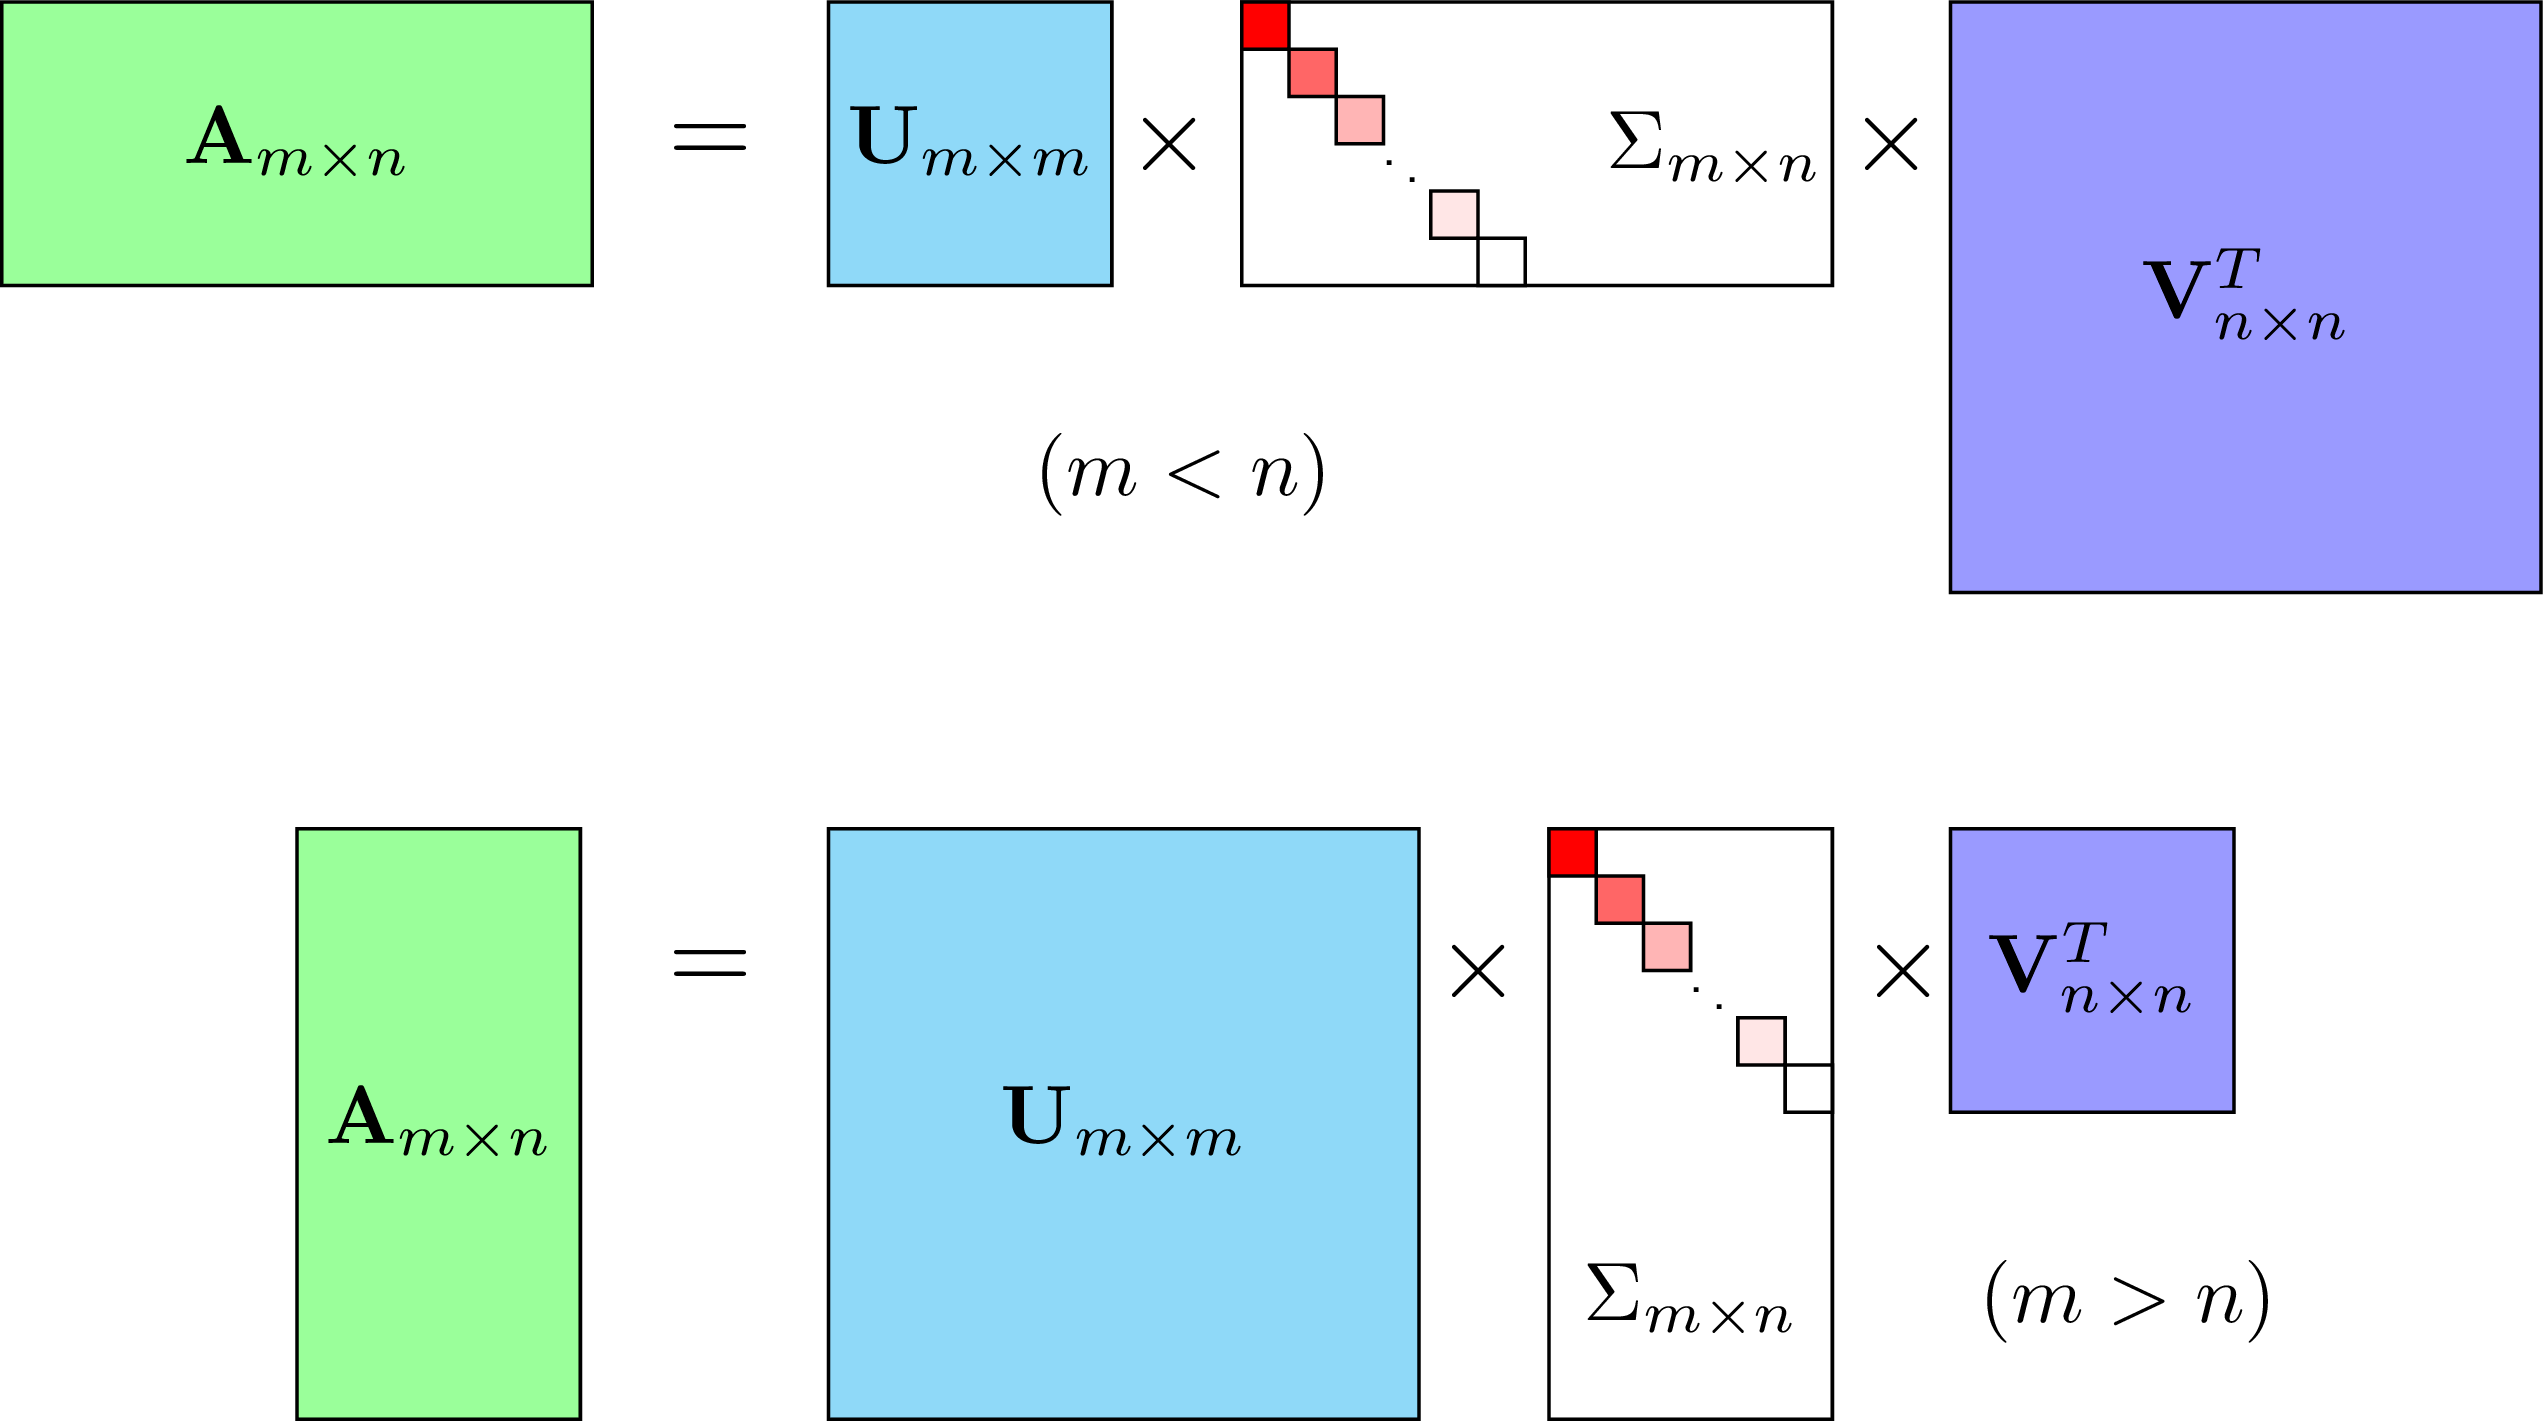

An abitrary matrix $\mathbf{A}_{m \times n}$ can be factorized into:

$$\mathbf{A}_{m \times n} = \mathbf{U}_{m \times m}\mathbf{\Sigma}_{m \times n} (\mathbf{V}_{n \times n})^T$$

where, $\mathbf{U}, \mathbf{V}$ are orthogonal matrices, $\mathbf{\Sigma}$ is non-square diagonal matrix with diagonal elements satisfied $\sigma_1 \geq \sigma_2 \geq \dots \geq\sigma_r \geq 0 = 0 = \dots = 0$ and r is rank of matrix $\mathbf{A}$. 

Although $\Sigma$ is not a square matrix, it can still be considered as an diagonal matrix if it do not have any positive elements other than those inside the main diagonal (position has the same row index and column index).

Number of non-zero elements in $\Sigma$ is rank of matrix $\mathbf{A}$.

Normally, there are afew large value $\sigma_i$. The others are very small and near 0. We an approximate $\mathbf{A}$ by sum of k 1-ranked matrices 
$$\mathbf{A} \approx \mathbf{A}_k = \mathbf{U}_k \Sigma_k (\mathbf{V}_k)^T = \sigma_1 \mathbf{u}_1 \mathbf{v}^T_1 + \sigma_2\mathbf{u}_2\mathbf{v}_2^2 + \dots + \sigma_k\mathbf{u}_k\mathbf{v}k^T$$


In [ ]:
from numpy import linalg as LA

class SVD_RS(object):
    
    def __init__(
        self,
        Y_data, # utility matrix
        K, # number of latent feature
        user_based = 1): # mode user based (1) or item based (0)

        self.Y_data = Y_data
        self.K = K
        self.user_based = user_based

        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = int(np.max(Y_data[:, 0])) + 1 
        self.n_items = int(np.max(Y_data[:, 1])) + 1            

        #self.all_users = self.Y_data[:,0] # all users (may be duplicated)
        self.n_ratings = Y_data.shape[0]
        # normalized data
        self.Ybar_data = self.Y_data.copy().astype(np.float32)

    def normalize_Y(self):
        if self.user_based:
            user_col = 0
            item_col = 1
            n_objects = self.n_users

        # if we want to normalize based on item, just switch first two columns of data
        else: # item baseded
            user_col = 1
            item_col = 0 
            n_objects = self.n_items

        users = self.Y_data[:, user_col] 
        self.mu = np.zeros((n_objects,))
        for n in range(n_objects):
            # row indices of rating done by user n
            # since indices need to be integers, we need to convert
            ids = np.where(users == n)[0].astype(np.int32)
            # indices of all ratings associated with user n
            item_ids = self.Y_data[ids, 1] 
            # and the corresponding ratings 
            ratings = self.Y_data[ids, 2].astype(np.float32)
            # take mean
            m = np.mean(ratings) 
            if np.isnan(m):
                m = 0 # to avoid empty array and nan value
            self.mu[n] = m
            # normalize
            self.Ybar_data[ids, 2] = ratings - self.mu[n]

        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
            (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.todense()


    def fit(self): 
        """
        matrix factorization using SVD
        """
        self.normalize_Y()
        U, S, V = LA.svd(self.Ybar)
        Uk = U[:, :self.K]
        Sk = S[:self.K]
        Vkt = V[:self.K, :]
        self.res = Uk.dot(np.diag(Sk)).dot(Vkt)
        
    def pred(self, u, i):
        """ 
        predict the rating of user u for item i 
        """
        u = int(u)
        i = int(i)
        
        if self.user_based:
            bias = self.mu[u]
        else: 
            bias = self.mu[i]
        pred = self.res[i, u] + bias 
        if pred < 1:
            return 1 
        if pred > 5: 
            return 5 
        return pred 
        
    
    def pred_for_user(self, user_id):
        ids = np.where(self.Y_data_n[:, 0] == user_id)[0]
        items_rated_by_u = self.Y_data_n[ids, 1].tolist()              
        
        y_pred = self.X.dot(self.W[:, user_id]) + self.mu[user_id]
        predicted_ratings= []
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                predicted_ratings.append((i, y_pred[i]))
        
        return predicted_ratings
    
    def evaluate_RMSE(self, rate_test):
        n_tests = rate_test.shape[0]
        SE = 0 # squared error
        for n in range(n_tests):
            pred = self.pred(rate_test[n, 0], rate_test[n, 1])
            SE += (pred - rate_test[n, 2])**2 

        RMSE = np.sqrt(SE/n_tests)
        return RMSE

In [ ]:
rs = SVD_RS(rate_train, K = 10, user_based = 1)
rs.fit()
# evaluate on test data
RMSE = rs.evaluate_RMSE(rate_test)
print('User-based MF, RMSE =', RMSE)

User-based MF, RMSE = 1.0185374536524834


In [ ]:
rs = SVD_RS(rate_train, K = 10, user_based = 0)
rs.fit()
# evaluate on test data
RMSE = rs.evaluate_RMSE(rate_test)
print('Item-based MF, RMSE =', RMSE)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Item-based MF, RMSE = 1.0148652433653447
